In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = torch.linspace(0,799,800)

In [3]:
x

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
        108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
        120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
        132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
        144., 145., 146., 147., 148., 14

In [5]:
y = torch.sin(x*2*3.1416/40) # multiply x by pi and divide by frequency

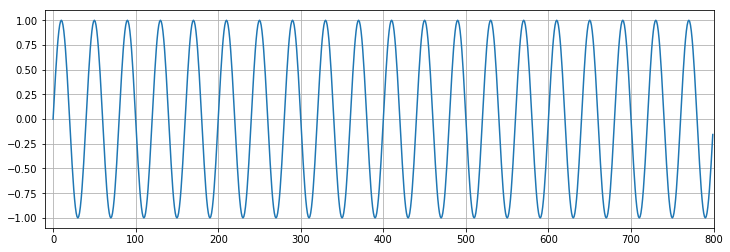

In [8]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy())

In [9]:
# Sequence train-test split

test_size = 40 # save last 40 data points for testing
train_set = y[:-test_size]
test_set = y[-test_size:]

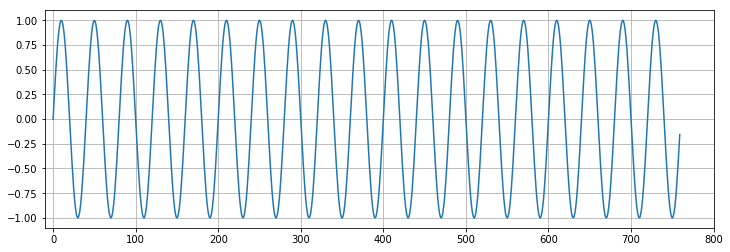

In [10]:
plt.figure(figsize=(12,4))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(train_set.numpy())

In [12]:
# takes available training data and chops into batches
def input_data(seq,ws): # seq = sequence, ws = window size
    
    out = [] # ([0,1,2,3],[4]) , ([1,2,3,4],[5]) , ....
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1] # predict one point into the future
        out.append((window,label))
    
    return out

In [13]:
window_size = 40

train_data = input_data(train_set,window_size)

In [15]:
len(train_data)
# 0-799 --> 800
# 800-40 --> 760
# 760-40 --> 720

720

In [21]:
# Look at first tensor
train_data[0]

(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
          7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
          1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
          7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
         -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
         -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
         -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
         -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]),
 tensor([1.4480e-05]))

In [22]:
# Output of first tensor is the last value in the next
train_data[1]

(tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
          8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
          9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
          5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
         -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01,
         -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01, -1.0000e+00,
         -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01, -7.0710e-01,
         -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01,  1.4480e-05]),
 tensor([0.1564]))

In [23]:
# Create LSTM model

In [24]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=50,out_size=1):        # hidden_size = number of neurons
        
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        self.linear = nn.Linear(hidden_size,out_size)
        
        # (H, C)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        
        pred = self.linear(lstm_out.view(len(seq),-1))
        
        # [ 1,2,3 ]   [4]   ---> [ 1,2,3,4 ]  ---> [4] only want the forecasted value
        
        return pred[-1]

In [25]:
torch.manual_seed(42)

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [26]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [27]:
for p in model.parameters():
    print(p.numel())

200
10000
200
200
50
1


In [28]:
# Train and forecast

Epoch 0   Loss 0.0921287089586258
Performance on test range: 0.6071590781211853


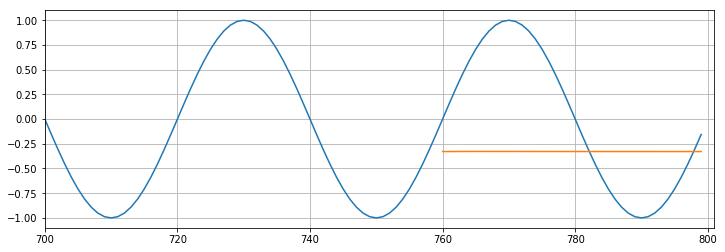

Epoch 1   Loss 0.06506764143705368
Performance on test range: 0.565098762512207


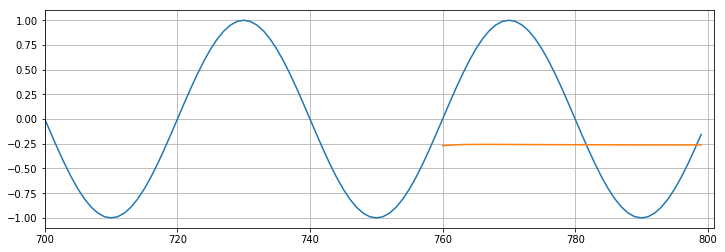

Epoch 2   Loss 0.041980478912591934
Performance on test range: 0.5199716687202454


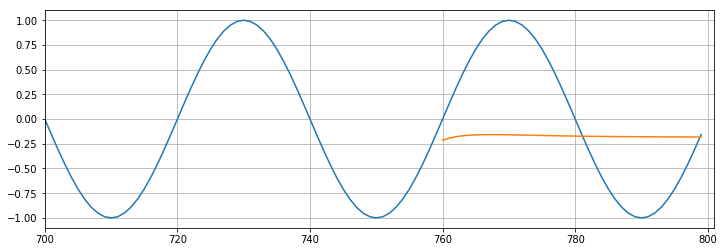

Epoch 3   Loss 0.017842764034867287
Performance on test range: 0.42209962010383606


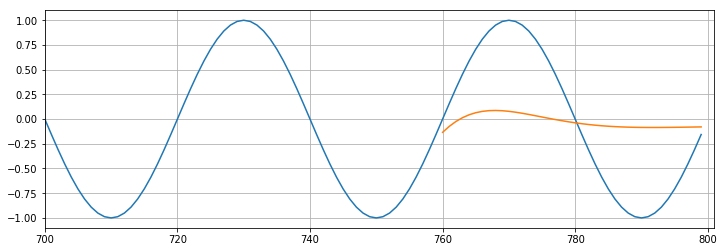

Epoch 4   Loss 0.0028871013782918453
Performance on test range: 0.16624100506305695


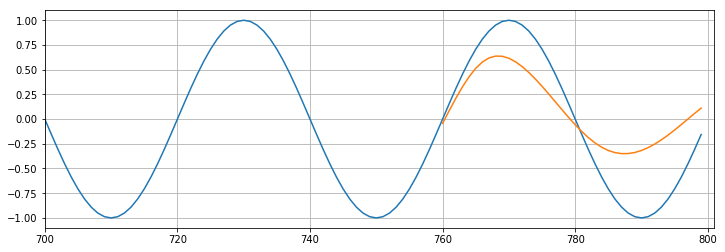

Epoch 5   Loss 0.00032007365371100605
Performance on test range: 0.03055436909198761


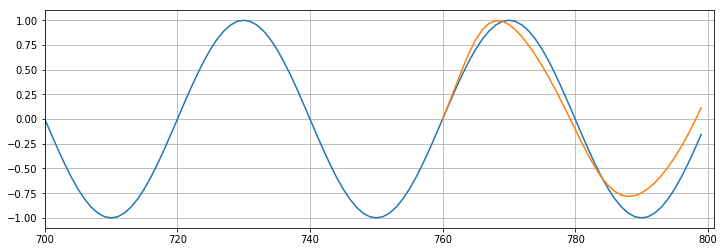

Epoch 6   Loss 0.00012969138333573937
Performance on test range: 0.014990190975368023


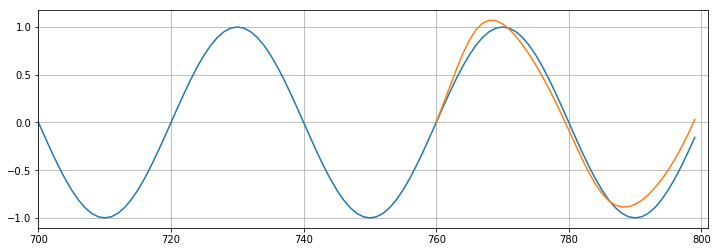

Epoch 7   Loss 0.00012006733595626429
Performance on test range: 0.011856673285365105


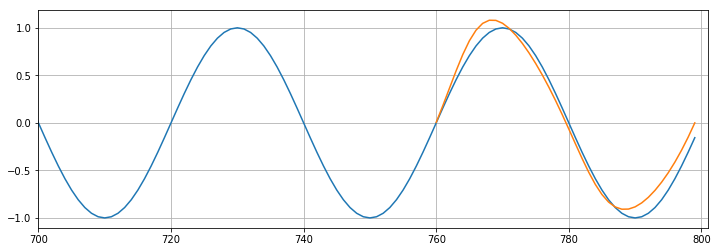

Epoch 8   Loss 0.00012655690079554915
Performance on test range: 0.010163797065615654


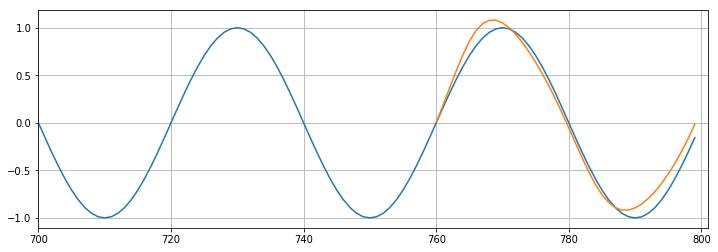

Epoch 9   Loss 0.00013195407518651336
Performance on test range: 0.008897597901523113


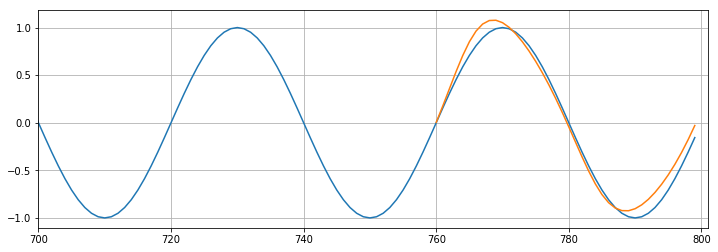

In [29]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq,y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {i}   Loss {loss.item()}')
    
    preds = train_set[-window_size:].tolist()
    
    
    
    for f in range(future):
        
        seq = torch.FloatTensor(preds[-window_size:])
        
        with torch.no_grad():
            
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            
            preds.append(model(seq).item())
    
    loss = criterion(torch.tensor(preds[-window_size:]),y[760:])
    
    print(f'Performance on test range: {loss}')
    
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800),preds[window_size:])
    plt.show()

In [30]:
# Train model on all data and forecast into the unknown future

epochs = 15
window_size = 40
future = 40

all_data = input_data(y,window_size)
len(all_data)

760

In [31]:
import time
start_time = time.time()


for i in range(epochs):
    
    for seq,y_train in all_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {i}   Loss {loss.item()}')



total_time = time.time() - start_time
print(total_time/60)

Epoch 0   Loss 0.00013452860002871603
Epoch 1   Loss 0.00013442803174257278
Epoch 2   Loss 0.0001323175529250875
Epoch 3   Loss 0.0001287955674342811
Epoch 4   Loss 0.00012434215750545263
Epoch 5   Loss 0.00011931319022551179
Epoch 6   Loss 0.00011398104106774554
Epoch 7   Loss 0.00010853933781618252
Epoch 8   Loss 0.00010312659287592396
Epoch 9   Loss 9.78425596258603e-05
Epoch 10   Loss 9.274225158151239e-05
Epoch 11   Loss 8.787704427959397e-05
Epoch 12   Loss 8.325872477144003e-05
Epoch 13   Loss 7.890000415500253e-05
Epoch 14   Loss 7.480505882995203e-05
3.4124953031539915


In [32]:
# Forecast into the unknown future

preds = y[-window_size:].tolist()

for i in range(future):
    
    seq = torch.FloatTensor(preds[-window_size:])
    
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        preds.append(model(seq).item())

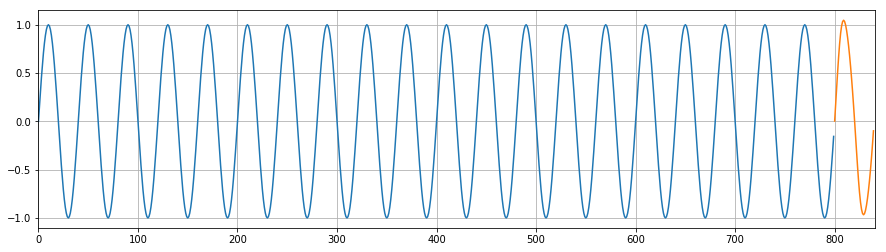

In [36]:
plt.figure(figsize=(15,4))
plt.xlim(0,841)
plt.grid(True)
plt.plot(y.numpy())
# Plotting forecast
plt.plot(range(800,800+future),preds[window_size:])
plt.show()